In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

In [3]:
image_path = "/content/drive/MyDrive/imgae processing lab/"

## Get Image Size

In [4]:
# Image Size in Byte
def image_size(img):
  return os.path.getsize(img)

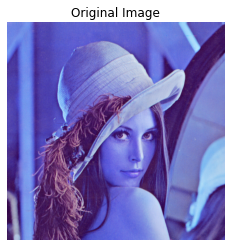

In [5]:
img = cv2.imread(f'{image_path}image.tiff')
show_image(img, "Original Image");

In [6]:
# Uncompressed Original Image Size
image_size(f'{image_path}image.tiff')

786572

## Convert To GrayScale

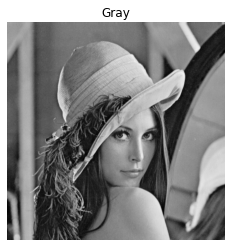

In [9]:
gray_original = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_image(gray_original, "Gray")

In [10]:
gray_original.shape[0], gray_original.shape[1]

(512, 512)

## Calculate Bit Rate

In [13]:
def find_bit_rate(gray_image):
  cv2.imwrite(f'{image_path}gray.tiff', gray_image)
  gray_width, gray_height = gray_image.shape[0], gray_image.shape[1]
  gray_size = image_size(f'{image_path}gray.tiff')
  bit_rate = (gray_size * 8) / (gray_width * gray_height)

  return bit_rate

In [14]:
# For Uncompressed Image
find_bit_rate(gray_original)

6.41241455078125

In [15]:
# Uncompressed Grayscale Image Size
image_size(f'{image_path}gray.tiff')

210122

## Function Calculate Entropy

In [16]:
def find_entropy(img):
  marg = np.histogramdd(np.ravel(img), bins=256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  entropy = -np.sum(np.multiply(marg, np.log2(marg)))
  
  return entropy

In [17]:
entropy = find_entropy(gray_original)

entropy

7.445060346118032

In [18]:
def splt2(img):
  const = 18
  [row, col] = np.shape(img)
  pred1 = np.zeros((row+1, col+1))
  pred11 = np.zeros((row+1, col+1))

  pred1[0, :] = const * np.ones((1, col+1))
  pred1[1: row+1, 0] = const
  pred1[1: row+1, 1: col+1] = img

  for i in range(1, row):
    for j in range(1, col):
      pred11[i, j] = 0.5*(pred1[i, j-1] + pred1[i-1, j])

  pred11 = pred11[1: row+1, 1:col+1]
  pred11 = img - np.fix(pred11)

  return pred11

In [19]:
compressed_img = splt2(gray_original)

In [20]:
# Compressed Image
find_entropy(compressed_img)

4.317027228342102

In [21]:
def temporal_sptl2(img, c):
    const = 5
    case_name = '';
    [row, col] = np.shape(img)
    pred1 = np.zeros((row+1, col+1))
    pred11 = np.zeros((row+1, col+1))

    pred1[0, :] = const * np.ones((1, col+1))
    pred1[1: row+1, 0] = const
    pred1[1: row+1, 1:col+1] = img
    
    #X=B
    if c==1:
        case_name = 'X=B'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j]

    #X=C
    if c==2:
        case_name = 'X=C'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j-1]

    #X=A
    if c==3:
        case_name = 'X=A'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1]

    #X=(A+B)/2
    if c==4:
        case_name = 'X=(A+B)/2'    
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = 0.5 * (pred1[i][j-1] + pred1[i-1][j])

    #X=A+B-C
    if c==5:
        case_name = 'X=A+B-C'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1] + pred1[i-1][j] - pred1[i-1][j-1]

    #X=A+(B-C)/2            
    if c==6:
        case_name = 'X=A+(B-C)/2'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1] + (0.5 * (pred1[i-1][j] - pred1[i-1][j-1]))
                
    #X=B+(A-C)/2
    if c==7:
        case_name = 'X=B+(A-C)/2'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j] + (0.5 * (pred1[i][j-1] - pred1[i-1][j-1]))
    
    pred11 = pred11[1:row+1, 1:col+1]
    pred11 = img - np.fix(pred11)
    pred11 = pred11.astype('double')

    return {'case_name': case_name, 'value': pred11}

In [22]:
for i in range(1, 8):
  vars()[f'temp_comp_{i}'] = temporal_sptl2(gray_original, i)

In [23]:
results = [{'case_name': 'Original', 'entropy': find_entropy(gray_original)}]

In [24]:
for i in range(1, 8):
  vars()[f'entropy_temp_comp_{i}'] = find_entropy(vars()[f'temp_comp_{i}']['value'])

  results.append({'case_name': vars()[f'temp_comp_{i}']['case_name'], 'entropy': vars()[f'entropy_temp_comp_{i}']})

  print('Case Name: ', vars()[f'temp_comp_{i}']['case_name'], '= ', vars()[f'entropy_temp_comp_{i}'])

Case Name:  X=B =  4.322433463072068
Case Name:  X=C =  4.717568879994386
Case Name:  X=A =  4.620526039129235
Case Name:  X=(A+B)/2 =  4.319308397727192
Case Name:  X=A+B-C =  4.5336619806509715
Case Name:  X=A+(B-C)/2 =  4.4198684538801105
Case Name:  X=B+(A-C)/2 =  4.361341627178347


In [25]:
results

[{'case_name': 'Original', 'entropy': 7.445060346118032},
 {'case_name': 'X=B', 'entropy': 4.322433463072068},
 {'case_name': 'X=C', 'entropy': 4.717568879994386},
 {'case_name': 'X=A', 'entropy': 4.620526039129235},
 {'case_name': 'X=(A+B)/2', 'entropy': 4.319308397727192},
 {'case_name': 'X=A+B-C', 'entropy': 4.5336619806509715},
 {'case_name': 'X=A+(B-C)/2', 'entropy': 4.4198684538801105},
 {'case_name': 'X=B+(A-C)/2', 'entropy': 4.361341627178347}]

In [71]:
# Calculate The Minimum Entropy
def find_minimum_entropy(results):
  minimum_val = 100
  i = -1

  for result in results:
    i = i + 1
    if result['entropy'] < minimum_val:
      minimum_val = result['entropy']
      case_name = result['case_name']
      min_index = i
  
  return {'case': case_name, 'value': minimum_val, 'min_index': min_index}

In [26]:
results_pd = pd.DataFrame(results)

## Entropy

In [27]:
results_pd

,case_name,entropy
0,Original,7.445060
1,X=B,4.322433
2,X=C,4.717569
3,X=A,4.620526
4,X=(A+B)/2,4.319308
5,X=A+B-C,4.533662
6,X=A+(B-C)/2,4.419868
7,X=B+(A-C)/2,4.361342


In [72]:
min_entropy = find_minimum_entropy(results)
min_entropy

{'case': 'X=(A+B)/2', 'min_index': 4, 'value': 4.319308397727192}

## Plot

In [73]:
index_of_minimum_entropy = min_entropy['min_index']

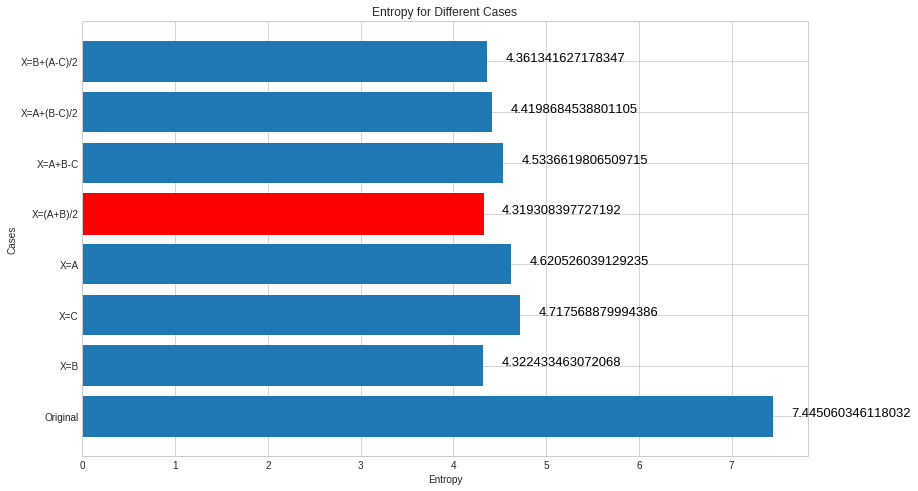

In [98]:
# Plot Entropy
plt.style.use('seaborn-whitegrid') # style theme of plots

fig, ax = plt.subplots(figsize=(13, 8))

ax.set(title="Entropy for Different Cases",
       xlabel="Entropy",
       ylabel="Cases")

y = list(results_pd['entropy'])

for i, v in enumerate(y):
    ax.text(v + 0.2, i, str(v), 
            color = 'black', fontsize=13)

bar_list = ax.barh(results_pd['case_name'], width=results_pd['entropy'])

bar_list[index_of_minimum_entropy].set_color('r')

plt.show();

In [55]:
print(f"Minimum Entropy is for case: {min_entropy['case']} and the value is: {min_entropy['value']}")

Minimum Entropy is for case: X=(A+B)/2 and the value is: 4.319308397727192
